<h3> Train a Neural Network only using numpy

In [243]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [244]:
data = pd.read_csv('MNIST_train.csv')
display(data.shape, data.head())

(42000, 785)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3> Basic preprocessing of the data

In [227]:
# Shuffle dataset before splitting to train and validation
data = data.sample(frac=1)

In [248]:
data = np.array(data)
print(data, '\n''\n', data.shape)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]] 

 (42000, 785)


In [229]:
# 42k images with 784 pixels each (+1 label dimension)
m, n = data.shape
print(m, n)

42000 785


In [249]:
#split to validation and train sets

train_data = data[1000:m]
train_data = train_data.T
Y_train = train_data[0]
X_train = train_data[1:n] #skip label dimension
X_train = X_train/255 # normalize the pixel intensities to the range [0, 1]
val_data = data[0:1000]
val_data = val_data.T
Y_val = val_data[0]
X_val = val_data[1:n]/255

print("train data dimensions:", train_data.shape) 
print("X train dimensions:", X_train.shape) 
print("Y train dimensions:", Y_train.shape) 

train data dimensions: (785, 41000)
X train dimensions: (784, 41000)
Y train dimensions: (41000,)


<h3> Basic functions for the every training phase

In [273]:
def init_parameters():
    """
    Initialize the parameters for a two-layer neural network around zero
    """
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5 
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(x):   
    """
    Compute the Rectified Linear Unit (ReLU) activation function.
    """
    return np.maximum(0, x)

def softmax(x):
    """
    Compute the softmax activation function.
    """
    # Ensure numerical stability by subtracting the maximum value
    exp_x = np.exp(x)
    A = exp_x / sum(exp_x) 
    return A

def forward_propagation(W1, b1, W2, b2, X):
    """
    Input data undergoing weighted summations 
    and activation function transformations
    """
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def one_hot(Y):
    """
    Converts a vector of class labels Y into 
    a one-hot encoded matrix where each column 
    represents a class, and for each sample.
    Only the column corresponding to its 
    class label contains a 1, 
    while all other columns contain 0s.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def ReLU_derivative(x):
    return x > 0

def back_propagation(Z1, A1, Z2, A2, W2, X, Y):
    """
    How much the weights and biases contributed to
    the deviation of the prediction from the label
    """
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2) 
    dZ1 = W2.T.dot(dZ2) * ReLU_derivative(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2
    
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Update the parameters of a two-layer neural network.
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [275]:
def gradient_descent(X, Y, alpha, iterations, tolerance=0.01):
    """
    Function to train the NN. Forwards the input, backwards the error and 
    updates the parameters. Incorporates also an early stop functionality through
    tolerence parameters.
    """
    W1, b1, W2, b2 = init_parameters()
    accuracies =[0]
    accuracy_per_epoch = {}
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
             
        if i % 50 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(get_predictions(A2), Y)
            print("Accuracy:", accuracy)
            
            accuracy_per_epoch[i] = accuracy
            if accuracy - accuracies[-1] >=  tolerance:
                accuracies.append(accuracy)
            else:
                print('stopped training')
                break       
            
    return W1, b1, W2, b2, accuracy_per_epoch

<h3> Display training results

In [276]:
W1, b1, W2, b2, accuracy_per_epoch = gradient_descent(X_train, Y_train, 0.1, 800)

Iteration:  0
Accuracy: 0.07741463414634146
Iteration:  50
Accuracy: 0.41673170731707315
Iteration:  100
Accuracy: 0.6114390243902439
Iteration:  150
Accuracy: 0.7017073170731707
Iteration:  200
Accuracy: 0.7480731707317073
Iteration:  250
Accuracy: 0.7790975609756098
Iteration:  300
Accuracy: 0.8006341463414635
Iteration:  350
Accuracy: 0.8162195121951219
Iteration:  400
Accuracy: 0.8279024390243902
Iteration:  450
Accuracy: 0.8360243902439024
stopped training


as seen the training stopped at around half of the epoch number set for the function

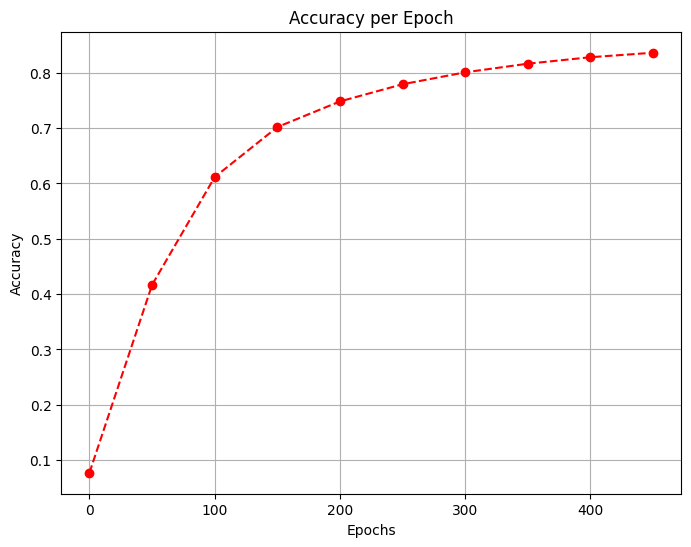

In [278]:
epochs = list(accuracy_per_epoch.keys())
accuracies = list(accuracy_per_epoch.values())

plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracies, marker='o', linestyle='--', color='red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

<h3> Test on the validation dataset

In [279]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [280]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
print('test set accuracy:', get_accuracy(val_predictions, Y_val))

test set accuracy: 0.845


The validation test accuracy is alsmost the same with training so we can assume we have build a model of good generalization and appropriate complexity level